In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig

The goal of this notebook is for the writer to learn the methods used in the Tesche/Clarke paper, and to provide training materials to physics undergrads.

The Tesche/Clarke paper lays out a model for two-junction SQUIDs. These are superconducting circuits that have two Josephson junctions arranged in parallel.

From Kaden, eqn (5.63)

$$ I = I_1 + I_2 = \bigg(I_c\sin{\phi_1} + \frac{V}{R} + C\frac{dV}{dt}\bigg) + \bigg(I_c\sin{\phi_2} + \frac{V}{R} + C\frac{dV}{dt}\bigg) = I'_c\sin(\phi') + \frac{V}{R'} + C'\frac{dV}{dt}$$

From Tesche/Clarke, eqns 13 to 16:

$$ j = \frac{\delta_1 - \delta_2 - 2\pi\phi_a}{\pi\beta} -\frac{\eta i}{2}$$

$$ v = \frac{1+\nu}{2}\frac{d\delta_1}{d\theta} + \frac{1 - \eta}{2}\frac{d\delta_2}{d\theta}$$

$$ \frac{d\delta_1}{d\theta} = \frac{i/2 - j - (1-\alpha)\sin{\delta_1}}{1-\rho} + v_{N1}$$

$$ \frac{d\delta_2}{d\theta} = \frac{i/2 + j - (1+\alpha)\sin{\delta_2}}{1+\rho} + v_{N2}$$

With constants $\alpha$, $\beta$, $\eta$, $\rho$.

$\alpha$ - current symmetry constant

$\beta$ - inductance symmetry constant

$\eta$ - flux symmetry constant (?)

$\rho$ - resistance symmetry constant

Want to add capacitance dependence to relationships above, will test thusly for now.

Below, we define the derivative we need for the Runge-Kutta 4th order algorithm. We supply a function that takes the current $\delta_1(\theta)$ and $\delta_2(\theta)$, along with the constant parameters, and returns the derivatives $\frac{\delta_1(\theta)}{d\theta}$ and $\frac{\delta_2(\theta)}{d\theta}$. In order to do this, we need to know j, since the derivitives depend on it. We can calculate the current j before we calculate the derivatives.

In [2]:
def qSquidRK(s,th,param):
    
#    Returns RHS of RSJ ODE; used by rk4
# Inputs
#    s      -   State vector [del1(theta), del2(theta)]
#    theta  -   time
#    params -   [alpha, beta, eta, rho, i, phia]
# Ouputs
#    deriv  -   Derivaties [d1(theta), d2(theta)]

    alpha = param[0]; beta = param[1];
    eta = param[2]; rho = param[3]
    i = param[4]; phia = param[5]
    del1 = s[0] # del_1(theta)
    del2 = s[1] # del_2(theta)
    j = (del1 - del2 - 2*np.pi*phia)/(np.pi*beta)- eta*i/2
    
    d1 = (.5*i-j-(1-alpha)*np.sin(del1))/(1-rho)
    d2 = (.5*i+j-(1+alpha)*np.sin(del2))/(1+rho)
    
    deriv = np.array([d1,d2])
    return(deriv)

Runge-Kutta Fourth Order

$$x(t + \tau) = x(t) + \frac{1}{6}\tau(\boldsymbol{F}_1 + 2\boldsymbol{F}_2 + 2\boldsymbol{F}_3 +\boldsymbol{F}_4)$$

$$\boldsymbol{F}_1=f(x,t)$$
$$\boldsymbol{F}_2=f\bigg(x+\frac{1}{2}\tau\boldsymbol{F}_1, t + \frac{1}{2}\tau\bigg)$$
$$\boldsymbol{F}_3=f\bigg(x+\frac{1}{2}\tau\boldsymbol{F}_2, t +\frac{1}{2}\tau\bigg)$$
$$\boldsymbol{F}_4=f\bigg(x+\tau\boldsymbol{F}_3, t + \tau\bigg)$$

In [2]:
def rk4(x,t,tau,derivsRK,param):
    
#   Runge-Kutta integrator 4th order
# INputs
#   x           -   current values of dependent variable
#   t           -   independent variable usually time
#   tau         -   step size usually time step
#   derivsRK    -   RHS of the ODE, fn defined somewhere
#   param       -   extra parameters passed to deriv fn
# Output
#   xout        -   new value of dependent variable after a step size tau

    half_tau = 0.5*tau
    
    F1 = derivsRK(x,t,param)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    
    F2 = derivsRK(xtemp,t_half,param)
    xtemp = x + half_tau*F2
    
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return xout    

We need a to do a loop. Inside the loop, we call rk4 to get the next values. Then we can (re)calculate j and the derivatives, calculate v, and store all those for recalling or plotting latter.

In [4]:
# Inputs
#                0    1    2    3   4   5
#     par = [alpha, beta, eta, rho, i, phia]
#     s = [del1_0,del_2_0]
#     tau = time step size
#     nStep = number of points
# Output
#           0     1    2   3   4           5           6
#     X = [theta,del1,del2,j,ddel1/dtheta,ddel2/dtheta,v]
def qSQUID(nStep,tau,s,par):
    theta = 0
    X = np.zeros([7,nStep])
    X[1,0] = s[0]
    X[2,0] = s[1]
    X[3,0] = (s[0] - s[1] - 2*np.pi*par[5])/(np.pi*par[1]) - par[2]*par[4]/2
    # j0 = (del10 - del20 - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    X[4,0] = (par[4]/2 - X[3,0] -(1-par[0])*np.sin(s[0]))/(1-par[3])
    # (i/2 - j0 -(1-alpha)*np.sin(del10))/(1-rho)
    X[5,0] = (par[4]/2 + X[3,0] -(1-par[0])*np.sin(s[1]))/(1+par[3])
    # (i/2 + j0 -(1-alpha)*np.sin(del20))/(1+rho)
    X[6,0] = (1+par[2])*X[4,0]/2 + (1-par[2])*X[5,0]/2
    # (1+eta)*d10/2 + (1-eta)*d20/2
    
    for iStep in range(nStep):
        
        s = rk4(s, theta, tau, qSquidRK, par)
        
        X[0,iStep] = theta
        X[1,iStep] = s[0]
        X[2,iStep] = s[1]
        X[3,iStep] = (s[0] - s[1] - 2*np.pi*par[5])/(np.pi*par[1]) - par[2]*par[4]/2
        X[4,iStep] = (.5*par[4]-X[3,iStep]-(1-par[0])*np.sin(s[0]))/(1-par[3])
        X[5,iStep] = (.5*par[4]+X[3,iStep]-(1+par[0])*np.sin(s[1]))/(1+par[3])
        X[6,iStep] = (1+par[2])*X[4,iStep]/2 + (1-par[2])*X[5,iStep]/2
        
        theta = theta + tau
        
    return(X)
    

In [5]:
s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0.25])
E = qSQUID(8000,.01,s,par)

Average voltage is 0.5917


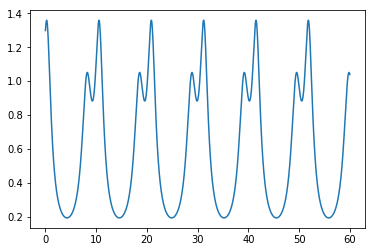

In [7]:
plt.plot(E[0,2000:]-20,E[6,2000:]) # plotting w x offset starting at i=2000
print("Average voltage is", round(sum(E[6,])/len(E[6,]),4))

Now we are ready to set up the system. We need to supply the constants as a parameter array, and the initial conditions as a state array. Some of the initial conditions are derived, so we can go ahead and do that so the first trip through the for loop has values to collect for j, v, and the derivatives. We also need a time axis, and to create the output data structure(s).

In [8]:
s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0])
D1 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0.25])
D2 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0,2.1,0.5])
D3 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0.8,1,0,0,2.1,0])
D4 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0.8,0,2.1,0])
D5 = qSQUID(80000,.001,s,par)

s = np.array([0,0])
par = np.array([0,1,0,0.8,2.1,0])
D6 = qSQUID(80000,.001,s,par)

Plot some stuff to check if it looks plausible.

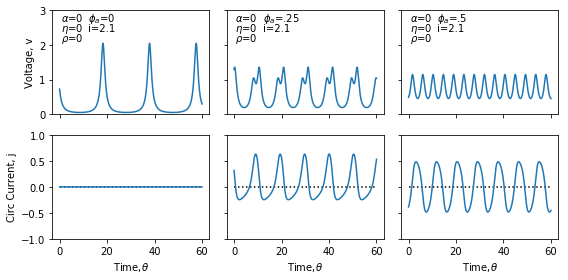

In [9]:
fig, ax = plt.subplots(2,3,figsize=(8,4))
ax1 = plt.subplot(2,3,1)
ax1.plot(D1[0,20000:]-20,D1[6,20000:])
ax1.text(.5,2.7,r"$\alpha$=0"); ax1.text(.5,2.4,r"$\eta$=0"); ax1.text(.5,2.1,r"$\rho$=0")
ax1.text(12,2.7,r"$\phi_a$=0"); ax1.text(12,2.4,r"i=2.1")
ax1.set(ylabel="Voltage, v",
       ylim=[0,3],
       xticklabels=([]))
ax2 = plt.subplot(2,3,2)
ax2.plot(D2[0,20000:]-20,D2[6,20000:])
ax2.text(.5,2.7,r"$\alpha$=0"); ax2.text(.5,2.4,r"$\eta$=0"); ax2.text(.5,2.1,r"$\rho$=0")
ax2.text(12,2.7,r"$\phi_a$=.25"); ax2.text(12,2.4,r"i=2.1")
ax2.set(ylim=[0,3],
       xticklabels=([]),
       yticklabels=([]))
ax3 = plt.subplot(2,3,3)
ax3.plot(D3[0,20000:]-20,D3[6,20000:])
ax3.text(.5,2.7,r"$\alpha$=0"); ax3.text(.5,2.4,r"$\eta$=0"); ax3.text(.5,2.1,r"$\rho$=0")
ax3.text(12,2.7,r"$\phi_a$=.5"); ax3.text(12,2.4,r"i=2.1")
ax3.set(ylim=[0,3],
       xticklabels=([]),
       yticklabels=([]))
ax4 = plt.subplot(2,3,4)
ax4.plot(D1[0,20000:]-20,D1[3,20000:])
ax4.hlines(0,0,60,linestyle='dotted')
ax4.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$",
       ylim=[-1,1])
ax5 = plt.subplot(2,3,5)
ax5.plot(D2[0,20000:]-20,D2[3,20000:])
ax5.hlines(0,0,60,linestyle='dotted')
ax5.set(ylim=[-1,1],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))
ax6 = plt.subplot(2,3,6)
ax6.plot(D3[0,20000:]-20,D3[3,20000:])
ax6.hlines(0,0,60,linestyle='dotted')
ax6.set(ylim=[-1,1],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))

fig.tight_layout()

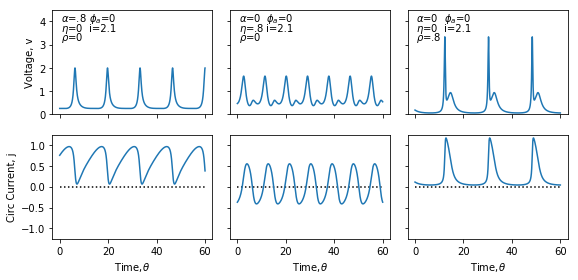

In [10]:
fig, ax = plt.subplots(2,3,figsize=(8,4))
ax1 = plt.subplot(2,3,1)
ax1.plot(D4[0,20000:]-20,D4[6,20000:])
ax1.text(.5,4,r"$\alpha$=.8"); ax1.text(.5,3.6,r"$\eta$=0"); ax1.text(.5,3.2,r"$\rho$=0")
ax1.text(12,4,r"$\phi_a$=0"); ax1.text(12,3.6,r"i=2.1")
ax1.set(ylabel="Voltage, v",
       ylim=[0,4.5],
       xticklabels=([]))
ax2 = plt.subplot(2,3,2)
ax2.plot(D5[0,20000:]-20,D5[6,20000:])
ax2.text(.5,4,r"$\alpha$=0"); ax2.text(.5,3.6,r"$\eta$=.8"); ax2.text(.5,3.2,r"$\rho$=0")
ax2.text(12,4,r"$\phi_a$=0"); ax2.text(12,3.6,r"i=2.1")
ax2.set(ylim=[0,4.5],
       xticklabels=([]),
       yticklabels=([]))
ax3 = plt.subplot(2,3,3)
ax3.plot(D6[0,20000:]-20,D6[6,20000:])
ax3.text(.5,4,r"$\alpha$=0"); ax3.text(.5,3.6,r"$\eta$=0"); ax3.text(.5,3.2,r"$\rho$=.8")
ax3.text(12,4,r"$\phi_a$=0"); ax3.text(12,3.6,r"i=2.1")
ax3.set(ylim=[0,4.5],
       xticklabels=([]),
       yticklabels=([]))
ax4 = plt.subplot(2,3,4)
ax4.plot(D4[0,20000:]-20,D4[3,20000:])
ax4.hlines(0,0,60,linestyle='dotted')
ax4.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$",
       ylim=[-1.25,1.25])
ax5 = plt.subplot(2,3,5)
ax5.plot(D5[0,20000:]-20,D5[3,20000:])
ax5.hlines(0,0,60,linestyle='dotted')
ax5.set(ylim=[-1.25,1.25],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))
ax6 = plt.subplot(2,3,6)
ax6.plot(D6[0,20000:]-20,D6[3,20000:])
ax6.hlines(0,0,60,linestyle='dotted')
ax6.set(ylim=[-1.25,1.25],
        xlabel=r"Time,$\theta$",
        yticklabels=([]))

fig.tight_layout()

In [152]:
# np.savetxt("D6.csv", D6, delimiter=",") # write out the file if you want

In [11]:
# build data for bias current v average voltage
# Run time series voltage, take time average
# store output as array vbar v ibias

nStep = 80000
tau = .01
i = np.arange(2.,6.,.1)
F61 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,i[k],0])
    S = qSQUID(nStep,tau,s,par)
    F61[0,k] = sum(S[6,])/len(S[6,])
    F61[1,k] = i[k]

In [12]:
i = np.arange(1.5,6.,.1)
F62 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,i[k],0.25])
    S = qSQUID(nStep,tau,s,par)
    F62[0,k] = sum(S[6,])/len(S[6,])
    F62[1,k] = i[k]

In [13]:
i = np.arange(1.,6.,.1)
F63 = np.zeros([2,len(i)])
for k in range(len(i)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,i[k],0.5])
    S = qSQUID(nStep,tau,s,par)
    F63[0,k] = sum(S[6,])/len(S[6,])
    F63[1,k] = i[k]

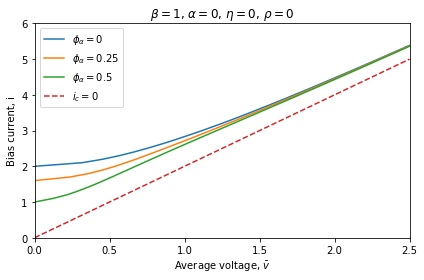

In [115]:
fig,ax = plt.subplots()
ax.plot(F61[0,],F61[1,],label=r"$\phi_{\alpha}=0$")
ax.plot(F62[0,],F62[1,],label=r"$\phi_{\alpha}=0.25$")
ax.plot(F63[0,],F63[1,],label=r"$\phi_{\alpha}=0.5$")
ax.plot(np.arange(0,2.6,.1),np.arange(0,5.2,.2),'--',
       label=r"$i_c=0$")
ax.set(title=r"$\beta=1$, $\alpha=0$, $\eta=0$, $\rho=0$",
       xlabel=r"Average voltage, $\bar{v}$",
       ylabel="Bias current, i",
       xlim=[0,2.5],ylim=[0,6.])
ax.legend()
fig.tight_layout()

In [126]:
# loop over applied fluxes to build
# vbar vx phi_a 'contor' plot

# for beta = 0.4

## need to make this a function that can be called
## from a gui

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)                # create input array
F71 = np.zeros([3,len(phia)])               # create ouput array
for k in range(len(phia)):                  # loop over phia s
    s = np.array([0,0])                     # set initial state vector to zero
    par = np.array([0,0.4,0,0,2.1,phia[k]]) # set parameter vector
    S = qSQUID(nStep,tau,s,par)             # run the sim
    F71[0,k] = phia[k]                      # enter phia s to output array
    F71[1,k] = sum(S[6,])/len(S[6,])        # store average voltage
    F71[2,k] = sum(S[3,])/len(S[3,])        # store average current

In [128]:
# as above,

# beta = 1

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F72 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,1,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F72[0,k] = phia[k]
    F72[1,k] = sum(S[6,])/len(S[6,])
    F72[2,k] = sum(S[3,])/len(S[3,])

In [131]:
# as above,

# beta = 2

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F73 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,2,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F73[0,k] = phia[k]
    F73[1,k] = sum(S[6,])/len(S[6,])
    F73[2,k] = sum(S[3,])/len(S[3,])

In [134]:
# as above,

# beta = 4

nStep = 8000
tau = .1
phia = np.arange(0,1.01,.01)
F74 = np.zeros([3,len(phia)])
for k in range(len(phia)):
    s = np.array([0,0])
    par = np.array([0,4,0,0,2.1,phia[k]])
    S = qSQUID(nStep,tau,s,par)
    F74[0,k] = phia[k]
    F74[1,k] = sum(S[6,])/len(S[6,])
    F74[2,k] = sum(S[3,])/len(S[3,])

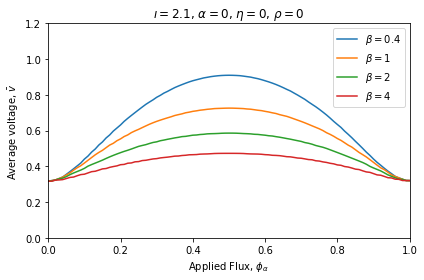

In [125]:
fig,ax = plt.subplots()
ax.plot(F71[0,],F71[1,],label=r"$\beta=0.4$")
ax.plot(F72[0,],F72[1,],label=r"$\beta=1$")
ax.plot(F73[0,],F73[1,],label=r"$\beta=2$")
ax.plot(F74[0,],F74[1,],label=r"$\beta=4$")
ax.set(title=r"$\i=2.1$, $\alpha=0$, $\eta=0$, $\rho=0$",
      xlabel=r"Applied Flux, $\phi_{\alpha}$",
      ylabel=r"Average voltage, $\bar{v}$",
      ylim=[0,1.2],xlim=[0,1.])
ax.legend()
fig.tight_layout()

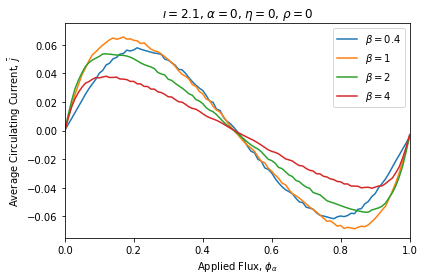

In [135]:
fig,ax = plt.subplots()
ax.plot(F71[0,],F71[2,],label=r"$\beta=0.4$")
ax.plot(F72[0,],F72[2,],label=r"$\beta=1$")
ax.plot(F73[0,],F73[2,],label=r"$\beta=2$")
ax.plot(F74[0,],F74[2,],label=r"$\beta=4$")
ax.set(title=r"$\i=2.1$, $\alpha=0$, $\eta=0$, $\rho=0$",
      xlabel=r"Applied Flux, $\phi_{\alpha}$",
      ylabel=r"Average Circulating Current, $\bar{j}$",
      ylim=[-.075,.075],xlim=[0,1.])
ax.legend()
fig.tight_layout()

#### Noise Model
Use psudorandom-number generator to make a set of Gaussian-distributed $v_k$ of zero mean and $<v_k^2> = \frac{2\Gamma}{\Delta\theta}$. With $<v_k>^2=0$, we take $\sigma_v^2 = \frac{2\Gamma}{\Delta\theta}$.

In [5]:
nStep = 8000000
tau = .1
Gamma = .0
v_k = np.zeros([3,nStep])
var = 4*np.pi*8.
for i in range(nStep):
    v_k[0,i] = i*tau
    v_k[1,i] = np.random.normal(0,2*Gamma/tau)
    v_k[2,i] = np.random.normal(0,2*Gamma/tau)

In [37]:
n = len(v_k[0,])
frq = np.arange(n)*tau/n
frq = frq[:n//2]
vtilda1 = fft.fft(v_k[1,])/n
vtilda1 = vtilda1[:n//2]
vtilda2 = fft.fft(v_k[2,])/n
vtilda2 = vtilda2[:n//2]

fig,ax = plt.subplots(1,3,figsize=[12,3])
ax1 = plt.subplot(1,3,1)
ax1.hist(v_k[1,],bins='auto',density=True)
ax1.hist(v_k[2,],bins='auto',density=True)
ax1.set(title=r'Histogram, $v_k$',
       xlabel='Voltage',
       ylabel='Density')
ax2 = plt.subplot(1,3,2)
ax2.plot(v_k[0,],v_k[1,])
ax2.plot(v_k[0,],v_k[2,])
ax2.set(title=r'Time series, $v_k$',
       xlabel=r'Time, $\theta$',
       ylabel=r'Voltage, $v_k$')
ax3 = plt.subplot(1,3,3)
ax3.loglog(frq,abs(vtilda1),frq,abs(vtilda2))
ax3.set(title='Frequency Domain',
       xlabel=r'Frequency',
       ylabel=r'Amplitude')
fig.tight_layout()

NameError: name 'v_k' is not defined

#### Single junction with noise


$$\frac{d\delta}{d\theta} = v = i - sin\delta + v_N$$


In [3]:
def snJJRK(s,t,param):
    
#    Returns RHS of single junction with noise RSJ ODE; used by rk4
# Inputs
#    s      -   State vector [del(theta)]
#    param -   [i, vN]
# Ouputs
#    deriv  -   Derivaties [d(theta)]
#    vN     -   noise voltage generaterd, for logging

    
    deriv = param[0] - np.sin(s) + param[1]             # d(del)/dtheta = v = i - sin(del) + vN
    return(deriv)

In [8]:
# Inputs
#                0    1
#     param = [i, Gamma]
#     s = [del_0] phase difference
#     tau = time step size# Inputs
#                0    1
#     param = [i, Gamma]
#     s = [del_0] phase difference
#     tau = time step size
#     nStep = number of points
# Output
#           0     1  2 3  
#     X = [theta,del,v,vN]
def snJJ(nStep,tau,s,param):
    var = 2*param[1]/tau                                # var = 2*Gamma/tau
    sd = var**.5                                        # std dev = var^.5, for gaussian noise
    theta = 0                                           # set time theta to zero
    X = np.zeros([4,nStep])                             # create output array
    vN = np.random.normal(0,sd)                         # generate initial voltage noise
    
    X[0,0] = theta                                      # record initial time theta
    X[1,0] = s                                          # record initial del, phase diff
    X[2,0] = param[0] - np.sin(s) + vN                  # record initial voltage
    X[3,0] = vN                                         # record initial voltage noise value
    
    par = np.array([param[0], tau, param[1]])           # generate param array for rk4 call, not used
    
    for iStep in range(nStep):                          # for loop through time
        vN = np.random.normal(0,sd)                     # generate random noise voltage, gaussian

        s = rk4(s, theta, tau, snJJRK, [param[0],vN])   # call rk4 with snJJRK to get next state value
        
        X[0,iStep] = theta                              # record time theta to output array
        X[1,iStep] = s                                  # record state, phase diff
        X[2,iStep] = param[0] - np.sin(s) + vN          # record v, i - sin(delta) + vn
        X[3,iStep] = vN                                 # record noise value for posterity
        
        theta = theta + tau                             # advance time for start of next cycle
        
    return(X)
#     nStep = number of points
# Output
#           0     1  2 3  
#     X = [theta,del,v,vN]
def snJJ(nStep,tau,s,param):
    var = 2*param[1]/tau                                # var = 2*Gamma/tau
    sd = var**.5                                        # std dev = var^.5, for gaussian noise
    theta = 0                                           # set time theta to zero
    X = np.zeros([4,nStep])                             # create output array
    vN = np.random.normal(0,sd)                         # generate initial voltage noise
    
    X[0,0] = theta                                      # record initial time theta
    X[1,0] = s                                          # record initial del, phase diff
    X[2,0] = param[0] - np.sin(s) + vN                  # record initial voltage
    X[3,0] = vN                                         # record initial voltage noise value
    
    par = np.array([param[0], tau, param[1]])           # generate param array for rk4 call, not used
    
    for iStep in range(nStep):                          # for loop through time
        vN = np.random.normal(0,sd)                     # generate random noise voltage, gaussian

        s = rk4(s, theta, tau, snJJRK, [param[0],vN])   # call rk4 with snJJRK to get next state value
        
        X[0,iStep] = theta                              # record time theta to output array
        X[1,iStep] = s                                  # record state, phase diff
        X[2,iStep] = param[0] - np.sin(s) + vN          # record v, i - sin(delta) + vn
        X[3,iStep] = vN                                 # record noise value for posterity
        
        theta = theta + tau                             # advance time for start of next cycle
        
    return(X)

In [5]:
# Inputs
#                0    1
#     param = [i, Gamma]
#     s = [del_0] phase difference
#     tau = time step size
#     nStep = number of points
# Output
#           0     1  2 3  
#     X = [theta,del,v,vN]
def snJJ(nStep,tau,s,param):
    var = 2*param[1]/tau                                # var = 2*Gamma/tau
    sd = var**.5                                        # std dev = var^.5, for gaussian noise
    theta = 0                                           # set time theta to zero
    X = np.zeros([2,nStep])                             # create output array
    vN = np.random.normal(0,sd)                         # generate initial voltage noise
    
    X[0,0] = theta                                      # record initial time theta
    X[1,0] = param[0] - np.sin(s) + vN                  # record initial voltage
                                                        # record initial voltage noise value
    
    par = np.array([param[0], tau, param[1]])           # generate param array for rk4 call, not used
    
    for iStep in range(nStep):                          # for loop through time
        vN = np.random.normal(0,sd)                     # generate random noise voltage, gaussian

        s = rk4(s, theta, tau, snJJRK, [param[0],vN])   # call rk4 with snJJRK to get next state value
        
        X[0,iStep] = theta                              # record time theta to output array
        X[1,iStep] = param[0] - np.sin(s) + vN          # record v, i - sin(delta) + vn
        
        theta = theta + tau                             # advance time for start of next cycle
        
    return(X)

In [24]:
# parameters for a single junction
# s - state, initial phase
s = 120 
# nStep - how long to run. 8e7 is long
nStep = 2500000 #80000000 #80000
# tau - time step size, in dimensionless theta
tau = .1
# i - bias current, in multiples of critical current
i = 1.05
# Gamma
Gamma = 0.001
param = np.array([i,Gamma])

In [25]:
# run single noisy Josephson junction sim with the above
# with nStep = 8e7
# start 11:13 PM
# stop 11:34 PM
# 21 minutes
N1 = snJJ(nStep,tau,s,param)

In [12]:
# store and read the data above
# this takes a while to write out too, 11:35, 11:42, 7 minutes
# 7.8 GB (!) my machine only has 16 GB RAM
# this may be worth converting data structures to pandas
##np.savetxt("snjj5e6.csv", N1, delimiter = ",")
# this takes a while too. 11:45, 11:56
# I am hitting the useful limit of RAM trying to load this file
# ...constantly virtual memory/page filing...
##N1 = np.genfromtxt('snjj8e7.csv', delimiter=",")

In [18]:
## del N1

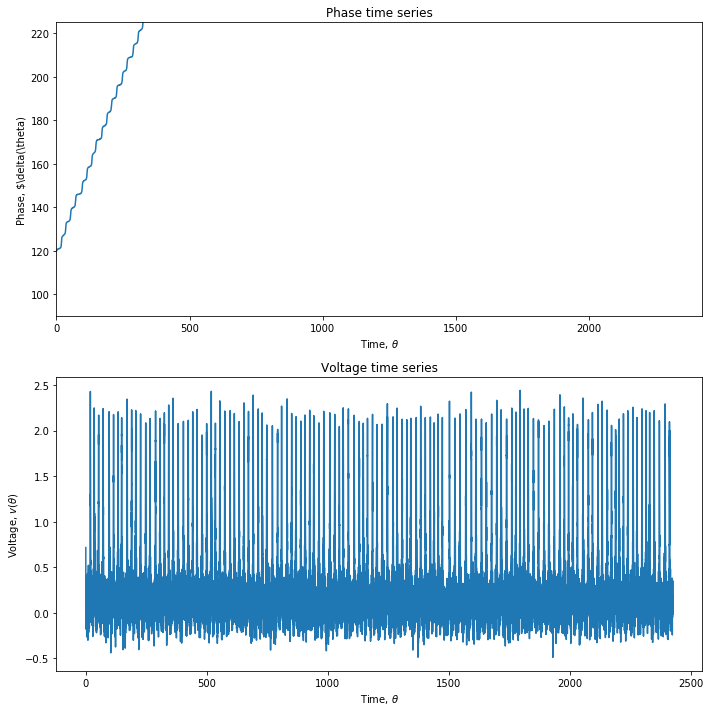

In [26]:
fig,ax = plt.subplots(2,1,figsize=[10,10])
ax1 = plt.subplot(2,1,1)
ax1.plot(N1[0,],N1[1,])
ax1.set(title=r'Phase time series',
       xlabel=r'Time, $\theta$',
       ylabel=r'Phase, $\delta(\theta)',
       xlim=[0,24243*tau], # xlim=[0,nStep*tau],
       ylim=[90,225])
       
ax2 = plt.subplot(2,1,2)
ax2.plot(N1[0,:24243],N1[2,:24243])
ax2.set(title=r'Voltage time series',
       xlabel=r'Time, $\theta$',
       ylabel=r'Voltage, $v(\theta)$',
       #xlim=[0,]*tau, # xlim=[0,nStep*tau],
       #ylim=[-2,8])
       )
fig.tight_layout()

In [33]:
N1[0,]*tau

array([0.000000e+00, 1.000000e-04, 2.000000e-04, ..., 4.999997e+02,
       4.999998e+02, 4.999999e+02])

#### Butterworth Filter
We're going to need a Butterworth filter to cutt off the high frequency information before running the fft, and thus save time by fft-ing a quite smaller data set.

In [12]:
# returns coeffs
def butter_lowpass(cutoff, fs, order = 6):
    nyq = .5*fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='low', analog = False)
    return b, a

# filters a set of data
def butter_lowpass_filter(data, cutoff, fs, order = 6):
    b, a = butter_lowpass(cutoff, fs, order = order)
    y = sig.filtfilt(b, a, data)
    return(y)



In [67]:
fs = .1**(-1) #.033
cutoff = 1e-2 
order = 4

In [68]:
b, a = butter_lowpass(cutoff, fs, order); nStep

2500000

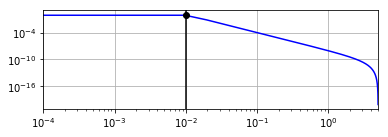

In [69]:
w, h = sig.freqz(b, a)
plt.subplot(2, 1, 1)
plt.loglog(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color = 'k')
plt.xlim(1e-4, .5*fs)
plt.grid()

0.3196794815033231


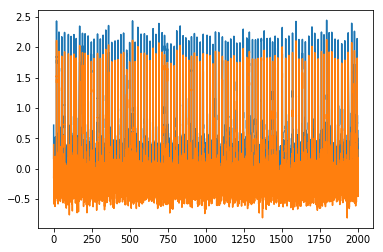

In [70]:
N2 = np.copy(N1)
vbar = sum(N2[2,])/len(N2[2,])
N2[2,] = N2[2,] - vbar
print(vbar)
plt.plot(N1[0,:20000],N1[2,:20000],N2[0,:20000],N2[2,:20000])

In [71]:
y = butter_lowpass_filter(N2[2,], cutoff, fs, order)

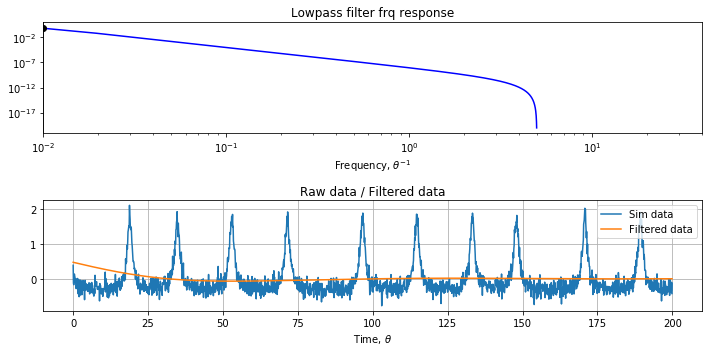

In [72]:
# Plot filtered time series over unfiltered to compare
fig, ax = plt.subplots(2,1,figsize=[10,5])
ax1 = plt.subplot(2,1,1)
ax1.loglog(0.5*fs*w/np.pi, np.abs(h), 'b')
ax1.loglog(cutoff, 0.5*np.sqrt(2), 'ko')
ax1.axvline(cutoff, color = 'k')
ax1.set(title='Lowpass filter frq response',
       xlabel=r'Frequency, $\theta^{-1}$',
       xlim=[1e-2, 40])
ax2 = plt.subplot(2,1,2)
ax2.plot(N2[0,0:2000],N2[2,0:2000],label='Sim data')
ax2.plot(N2[0,0:2000],y[0:2000],label='Filtered data')
ax2.set(title='Raw data / Filtered data',
       xlabel=r'Time, $\theta$')
ax2.grid()
ax2.legend()
fig.tight_layout()

In [65]:
N2[0,]

array([0.000000e+00, 1.000000e-01, 2.000000e-01, ..., 2.499997e+05,
       2.499998e+05, 2.499999e+05])

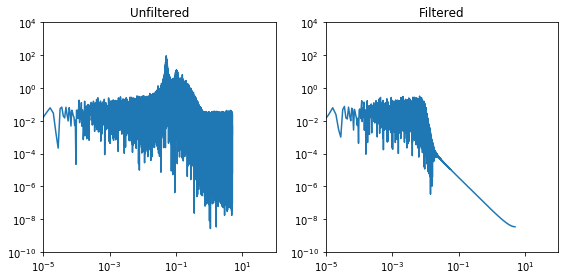

In [73]:
# Fourier transform, to frequency domain

sp1 = np.fft.fft(y/4*Gamma) #/4*Gamma
sp2 = np.fft.fft(N2[2,]/4*Gamma) #/4*Gamma
freq = np.fft.fftfreq(nStep, tau) #.shape[-1]
z=int(len(freq)/2)
#plt.plot(freq[:z], sp2.real[:z], freq[:z], sp1.real[:z])
fig, ax = plt.subplots(1,2,figsize = [8,4])
ax1 = plt.subplot(1,2,1)
ax1.loglog(freq[:z], sp2.real[:z]**2+sp2.imag[:z]**2)
ax1.set(title='Unfiltered',
       xlim=[1e-5,1e2],
       ylim = [1e-10, 1e4])
ax2 = plt.subplot(1,2,2)
ax2.loglog(freq[:z], sp1.real[:z]**2+sp1.imag[:z]**2)
ax2.set(title='Filtered',
       xlim=[1e-5,1e2],
       ylim = [1e-10, 1e4])
fig.tight_layout()

In [112]:
za = int(np.where(freq >= 1e-4)[0][[0]])
zb = int(np.where(freq == 5e-3)[0])

In [102]:
np.where(freq >= 1e-4)[0][[0]]

array([26], dtype=int64)

In [115]:
(sum(sp1.real[za:zb]**2+sp1.imag[za:zb]**2)/(zb-za))**.5

0.21657259456511985

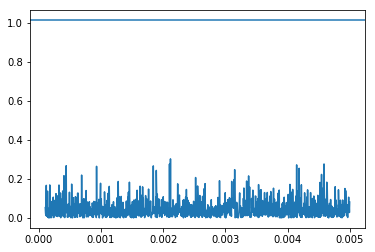

In [116]:
plt.plot(freq[za:zb], sp1.real[za:zb]**2+sp1.imag[za:zb]**2)
plt.axhline(1.011567)

In [63]:
s = 120
nStep = 80000
tau = .033
i = np.arange(.25,1.75,.2)
Gamma = 0.05

F11a1 = np.zeros([2,len(i)])

for k in range(len(i)):
    param = np.array([i[k],Gamma])
    X = snJJ(nStep,tau,s,param)
    F11a1[0,k] = sum(X[2,])/len(X[2,])
    F11a1[1,k] = i[k]

In [64]:
s = 120
nStep = 80000
tau = .033
i = np.arange(.25,1.75,.2)
Gamma = 0.1

F11a2 = np.zeros([2,len(i)])

for k in range(len(i)):
    param = np.array([i[k],Gamma])
    X = snJJ(nStep,tau,s,param)
    F11a2[0,k] = sum(X[2,])/len(X[2,])
    F11a2[1,k] = i[k]

In [65]:
s = 120
nStep = 80000
tau = .033
i = np.arange(.25,1.75,.2)
Gamma = 0.2

F11a3 = np.zeros([2,len(i)])

for k in range(len(i)):
    param = np.array([i[k],Gamma])
    X = snJJ(nStep,tau,s,param)
    F11a3[0,k] = sum(X[2,])/len(X[2,])
    F11a3[1,k] = i[k]


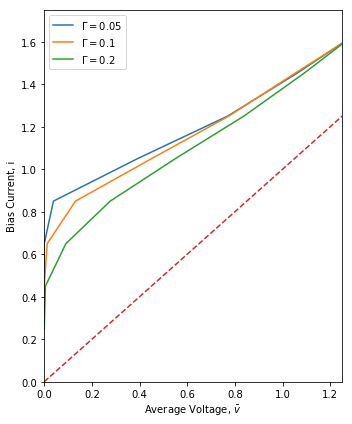

In [66]:
fig, ax = plt.subplots(figsize=[5,6])
ax.plot(F11a1[0,],F11a1[1,],label=r'$\Gamma=0.05$')
ax.plot(F11a2[0,],F11a2[1,],label=r'$\Gamma=0.1$')
ax.plot(F11a3[0,],F11a3[1,],label=r'$\Gamma=0.2$')
ax.plot([0,2],[0,2],'--')
ax.set(xlabel=r'Average Voltage, $\bar{v}$',
      ylabel=r'Bias Current, i',
      xlim=[0,1.25],
      ylim=[0,1.75])
ax.legend()
fig.tight_layout()

array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25,
       1.35, 1.45, 1.55, 1.65])